In [180]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
from prettytable import PrettyTable

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from gym import Env, Space, spaces
from gym.utils import seeding
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [181]:
class ListDiscrete(Space):
    def __init__(self, l) -> None:
        self.l = list(set(l))
        self.n = len(self.l)
    
    def sample(self):
        if self.n == 0:
            return None
        return np.random.choice(self.l)
    
    def contains(self, x):
        return x in self.l

In [184]:
class TestEnv(Env):
    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self) -> None:
        self.__max_step = 9
        
        # 0-8分别代表此次落子位置
        self.action_space = ListDiscrete(range(9))
        # 初始全零，下标0为：1、2分别代表黑白两方（1黑方先行），下标1-9为：0空、1黑方、2白方
        self.observation_space = spaces.Box(
            np.zeros(10, int), np.zeros(10, int) + 2)
        # 代表AI所属方（1或2）
        self.ai = None
        self._seed()
        self.state = None
        self.__step = None
        # 当前落子方
        self.current = None
        # 已经落子格子
        self.stated = None
        self.__all_stated_set = set(range(9))

    def _seed(self, seed=None):
        # 随机AI所属方
        self.ai = np.random.choice([1, 2])
    
    def _reset(self):
        self.__step = 0
        self.seed()
        self.state = [self.ai]
        self.state.extend(np.zeros(9, int).tolist())
        self.current = 1
        self.stated = []
        print(self.state)
        return np.array(self.state)

    def _step(self, action):
        if action is None:
            return np.array(self.state), 0, True, {}
        grid = self.state[1:]
        # 不可重复落子
        if action in self.stated:
            return np.array(self.state), -100, True, {}
        # 黑方先手
        grid = np.array(grid, int)
        dif = np.sum(grid == 1) - np.sum(grid == 2)
        if (dif == 0 and self.current == 1) or (dif == 1 and self.current == 2):
            pass
        else:
            return np.array(self.state), -100, True, {}
        # 胜负
        current = self.current
        grid[action] = current
        self.state = [self.ai]
        self.state.extend(grid.tolist())
        self.current = 3 - current
        self.stated.append(action)
        self.action_space = ListDiscrete(self.__all_stated_set.difference(self.stated))
        
        is_win = lambda b: \
            b[0:3].all() or b[3:6].all() or b[6:9].all() or \
            b[0::3].all() or b[1::3].all() or b[2::3].all() or \
            b[0::4].all() or b[2:7:2].all()
        if is_win(grid == current):
            if self.ai == current:
                reward = 20
            else:
                reward = -20
            return np.array(self.state), reward, True, {}

        reward = 0
        self.__step += 1
        if self.__step < self.__max_step:
            done = False
        else:
            done = True
        return np.array(self.state), reward, done, {}

    def _render(self, mode='ansi', close=False):
        table = PrettyTable()
        table.header = False
        grid = self.state[1:]
        table.add_row(grid[0:3])
        table.add_row(grid[3:6])
        table.add_row(grid[6:9])
        print(table)

    def _close(self):
        pass

In [185]:
env = TestEnv();
env.reset();
nb_actions = env.action_space.n
print(nb_actions)
env.render()

+---+---+---+
| 0 | 0 | 0 |
| 0 | 0 | 0 |
| 0 | 0 | 0 |
+---+---+---+
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9
+---+---+---+
| 0 | 0 | 0 |
| 0 | 0 | 0 |
| 0 | 0 | 0 |
+---+---+---+


In [142]:
env.reset();
for i in range(10):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # print(action, reward, done, info)
    env.render()
    if done:
        print(reward)
        break

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
+---+---+---+
| 0 | 1 | 0 |
| 0 | 0 | 0 |
| 0 | 0 | 0 |
+---+---+---+
+---+---+---+
| 0 | 1 | 0 |
| 0 | 0 | 0 |
| 2 | 0 | 0 |
+---+---+---+
+---+---+---+
| 0 | 1 | 0 |
| 0 | 1 | 0 |
| 2 | 0 | 0 |
+---+---+---+
+---+---+---+
| 0 | 1 | 0 |
| 0 | 1 | 2 |
| 2 | 0 | 0 |
+---+---+---+
+---+---+---+
| 0 | 1 | 0 |
| 0 | 1 | 2 |
| 2 | 1 | 0 |
+---+---+---+
20


In [87]:
env.step(6)

(array([2, 1, 0, 1, 2, 0, 0, 2, 1, 2]), 0, False, {})

In [124]:
env.action_space.sample()

5

In [187]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                704       
_________________________________________________________________
activation_37 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_38 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_39 (Activation)   (None, 64)                0         
__________

In [188]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=1000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [189]:
hist = dqn.fit(env, nb_steps=10000, visualize=False, verbose=2)

Training for 10000 steps ...
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    4/10000: episode: 1, duration: 0.234s, episode steps: 4, steps per second: 17, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.500 [1.000, 5.000], mean observation: 0.500 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    6/10000: episode: 2, duration: 0.002s, episode steps: 2, steps per second: 1045, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 6.000 [6.000, 6.000], mean observation: 0.200 [0.000, 1.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   10/10000: episode: 3, duration: 0.003s, episode steps: 4, steps per second: 1283, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.000 [1.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   13/10000: episode: 4, duration

  262/10000: episode: 59, duration: 0.003s, episode steps: 3, steps per second: 1190, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 1.333 [0.000, 4.000], mean observation: 0.433 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  265/10000: episode: 60, duration: 0.003s, episode steps: 3, steps per second: 997, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 5.000 [3.000, 6.000], mean observation: 0.333 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  269/10000: episode: 61, duration: 0.003s, episode steps: 4, steps per second: 1146, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 6.750 [5.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  272/10000: episode: 62, duration: 0.003s, episode steps: 3, steps per second: 1168, epi

  494/10000: episode: 112, duration: 0.004s, episode steps: 5, steps per second: 1208, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.400 [3.000, 6.000], mean observation: 0.500 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  500/10000: episode: 113, duration: 0.005s, episode steps: 6, steps per second: 1255, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.333 [0.000, 6.000], mean observation: 0.667 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  504/10000: episode: 114, duration: 0.003s, episode steps: 4, steps per second: 1177, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 1.250 [0.000, 3.000], mean observation: 0.400 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  509/10000: episode: 115, duration: 0.004s, episode steps: 5, steps per second: 1241

  725/10000: episode: 165, duration: 0.005s, episode steps: 8, steps per second: 1489, episode reward: -100.000, mean reward: -12.500 [-100.000, 0.000], mean action: 3.875 [0.000, 8.000], mean observation: 0.825 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  728/10000: episode: 166, duration: 0.003s, episode steps: 3, steps per second: 1048, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.333 [3.000, 5.000], mean observation: 0.433 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  733/10000: episode: 167, duration: 0.005s, episode steps: 5, steps per second: 1039, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 5.000 [0.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  740/10000: episode: 168, duration: 0.006s, episode steps: 7, steps per second: 1272

  958/10000: episode: 217, duration: 0.004s, episode steps: 6, steps per second: 1417, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.500 [1.000, 7.000], mean observation: 0.667 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  962/10000: episode: 218, duration: 0.004s, episode steps: 4, steps per second: 1100, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 5.750 [4.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  969/10000: episode: 219, duration: 0.005s, episode steps: 7, steps per second: 1317, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.143 [0.000, 8.000], mean observation: 0.657 [0.000, 2.000], loss: --, mean_absolute_error: --, mean_q: --
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  971/10000: episode: 220, duration: 0.002s, episode steps: 2, steps per second: 998,

 1104/10000: episode: 247, duration: 0.010s, episode steps: 2, steps per second: 203, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 7.000 [7.000, 7.000], mean observation: 0.200 [0.000, 1.000], loss: 781.558167, mean_absolute_error: 1.853154, mean_q: 0.504531
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1112/10000: episode: 248, duration: 0.034s, episode steps: 8, steps per second: 236, episode reward: -100.000, mean reward: -12.500 [-100.000, 0.000], mean action: 5.250 [2.000, 8.000], mean observation: 0.825 [0.000, 2.000], loss: 1017.557129, mean_absolute_error: 2.396193, mean_q: 0.530712
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1115/10000: episode: 249, duration: 0.016s, episode steps: 3, steps per second: 191, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.000 [2.000, 5.000], mean observation: 0.333 [0.000, 2.000], loss: 1462.823364, mean_absolute_error: 3.408637, mean_q: 0.578324
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1119/10000: episode: 250,

 1267/10000: episode: 281, duration: 0.022s, episode steps: 5, steps per second: 225, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.000 [1.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1315.140869, mean_absolute_error: 3.075064, mean_q: 0.740313
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1273/10000: episode: 282, duration: 0.024s, episode steps: 6, steps per second: 249, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.333 [0.000, 7.000], mean observation: 0.667 [0.000, 2.000], loss: 1018.827576, mean_absolute_error: 2.422865, mean_q: 0.734430
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1280/10000: episode: 283, duration: 0.026s, episode steps: 7, steps per second: 268, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 5.714 [3.000, 8.000], mean observation: 0.757 [0.000, 2.000], loss: 1050.588989, mean_absolute_error: 2.474882, mean_q: 0.699548
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1284/10000: episode: 284

 1422/10000: episode: 316, duration: 0.024s, episode steps: 6, steps per second: 246, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.500 [1.000, 8.000], mean observation: 0.667 [0.000, 2.000], loss: 1303.309204, mean_absolute_error: 3.052988, mean_q: 0.778237
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1427/10000: episode: 317, duration: 0.023s, episode steps: 5, steps per second: 220, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 5.200 [1.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 813.953430, mean_absolute_error: 1.962452, mean_q: 0.795465
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1432/10000: episode: 318, duration: 0.021s, episode steps: 5, steps per second: 242, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.400 [1.000, 5.000], mean observation: 0.600 [0.000, 2.000], loss: 658.906555, mean_absolute_error: 1.631989, mean_q: 0.734168
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1436/10000: episode: 319, 

 1574/10000: episode: 352, duration: 0.013s, episode steps: 3, steps per second: 225, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 3.000 [1.000, 7.000], mean observation: 0.433 [0.000, 2.000], loss: 729.358398, mean_absolute_error: 1.769948, mean_q: 0.776727
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1578/10000: episode: 353, duration: 0.018s, episode steps: 4, steps per second: 217, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.500 [1.000, 6.000], mean observation: 0.400 [0.000, 2.000], loss: 1256.598267, mean_absolute_error: 2.990412, mean_q: 0.741487
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1580/10000: episode: 354, duration: 0.013s, episode steps: 2, steps per second: 157, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 4.000 [4.000, 4.000], mean observation: 0.300 [0.000, 2.000], loss: 937.695679, mean_absolute_error: 2.230226, mean_q: 0.765059
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1584/10000: episode: 355, 

 1728/10000: episode: 386, duration: 0.029s, episode steps: 7, steps per second: 242, episode reward: 20.000, mean reward: 2.857 [0.000, 20.000], mean action: 3.000 [0.000, 6.000], mean observation: 0.671 [0.000, 2.000], loss: 1186.798950, mean_absolute_error: 2.817387, mean_q: 0.736974
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1734/10000: episode: 387, duration: 0.028s, episode steps: 6, steps per second: 218, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.833 [0.000, 6.000], mean observation: 0.667 [0.000, 2.000], loss: 890.264465, mean_absolute_error: 2.166493, mean_q: 0.703658
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1736/10000: episode: 388, duration: 0.010s, episode steps: 2, steps per second: 201, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.300 [0.000, 2.000], loss: 943.894531, mean_absolute_error: 2.306019, mean_q: 0.738748
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1741/10000: episode: 389, durati

 1875/10000: episode: 418, duration: 0.016s, episode steps: 4, steps per second: 246, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.250 [0.000, 4.000], mean observation: 0.500 [0.000, 2.000], loss: 783.758484, mean_absolute_error: 1.894673, mean_q: 0.916983
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1880/10000: episode: 419, duration: 0.024s, episode steps: 5, steps per second: 212, episode reward: 20.000, mean reward: 4.000 [0.000, 20.000], mean action: 3.600 [0.000, 6.000], mean observation: 0.520 [0.000, 2.000], loss: 941.653320, mean_absolute_error: 2.264108, mean_q: 0.915149
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1883/10000: episode: 420, duration: 0.013s, episode steps: 3, steps per second: 231, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 2.667 [0.000, 4.000], mean observation: 0.433 [0.000, 2.000], loss: 1303.300781, mean_absolute_error: 3.042794, mean_q: 0.898501
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 1887/10000: episode: 421, durati

 2029/10000: episode: 450, duration: 0.029s, episode steps: 7, steps per second: 238, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 2.857 [0.000, 7.000], mean observation: 0.757 [0.000, 2.000], loss: 1050.670776, mean_absolute_error: 2.495519, mean_q: 0.784640
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2035/10000: episode: 451, duration: 0.027s, episode steps: 6, steps per second: 224, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.833 [3.000, 7.000], mean observation: 0.567 [0.000, 2.000], loss: 966.054138, mean_absolute_error: 2.323621, mean_q: 0.809505
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2039/10000: episode: 452, duration: 0.017s, episode steps: 4, steps per second: 237, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.000 [0.000, 4.000], mean observation: 0.400 [0.000, 2.000], loss: 976.775391, mean_absolute_error: 2.323771, mean_q: 0.828447
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2043/10000: episode: 453, 

 2179/10000: episode: 483, duration: 0.029s, episode steps: 7, steps per second: 242, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.000 [0.000, 7.000], mean observation: 0.757 [0.000, 2.000], loss: 1030.739868, mean_absolute_error: 2.477720, mean_q: 0.754431
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2182/10000: episode: 484, duration: 0.016s, episode steps: 3, steps per second: 186, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 6.667 [6.000, 8.000], mean observation: 0.433 [0.000, 2.000], loss: 736.488770, mean_absolute_error: 1.846731, mean_q: 0.764172
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2185/10000: episode: 485, duration: 0.013s, episode steps: 3, steps per second: 228, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 2.667 [0.000, 4.000], mean observation: 0.433 [0.000, 2.000], loss: 1253.471558, mean_absolute_error: 2.954090, mean_q: 0.815432
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2189/10000: episode: 486,

 2318/10000: episode: 513, duration: 0.024s, episode steps: 6, steps per second: 249, episode reward: -20.000, mean reward: -3.333 [-20.000, 0.000], mean action: 4.333 [0.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 992.800720, mean_absolute_error: 2.376604, mean_q: 0.776781
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2325/10000: episode: 514, duration: 0.029s, episode steps: 7, steps per second: 244, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.143 [1.000, 7.000], mean observation: 0.657 [0.000, 2.000], loss: 805.584290, mean_absolute_error: 1.962032, mean_q: 0.786238
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2327/10000: episode: 515, duration: 0.010s, episode steps: 2, steps per second: 204, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 3.000 [3.000, 3.000], mean observation: 0.300 [0.000, 2.000], loss: 1253.341919, mean_absolute_error: 2.969982, mean_q: 0.796685
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2334/10000: episode: 516, dur

 2420/10000: episode: 538, duration: 0.037s, episode steps: 6, steps per second: 163, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.500 [1.000, 7.000], mean observation: 0.667 [0.000, 2.000], loss: 1020.663147, mean_absolute_error: 2.458835, mean_q: 0.781041
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2424/10000: episode: 539, duration: 0.035s, episode steps: 4, steps per second: 114, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 3.750 [3.000, 5.000], mean observation: 0.500 [0.000, 2.000], loss: 1136.990356, mean_absolute_error: 2.701176, mean_q: 0.787626
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2429/10000: episode: 540, duration: 0.033s, episode steps: 5, steps per second: 153, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.800 [2.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 812.697021, mean_absolute_error: 1.950797, mean_q: 0.764928
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2435/10000: episode: 541,

 2560/10000: episode: 569, duration: 0.021s, episode steps: 5, steps per second: 238, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 6.200 [3.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1190.098389, mean_absolute_error: 2.816231, mean_q: 0.799902
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2563/10000: episode: 570, duration: 0.017s, episode steps: 3, steps per second: 180, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.667 [4.000, 5.000], mean observation: 0.333 [0.000, 2.000], loss: 990.866394, mean_absolute_error: 2.354315, mean_q: 0.805641
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2569/10000: episode: 571, duration: 0.025s, episode steps: 6, steps per second: 242, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.500 [0.000, 6.000], mean observation: 0.667 [0.000, 2.000], loss: 785.351868, mean_absolute_error: 1.928202, mean_q: 0.788352
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2572/10000: episode: 572, 

 2698/10000: episode: 600, duration: 0.033s, episode steps: 5, steps per second: 150, episode reward: -20.000, mean reward: -4.000 [-20.000, 0.000], mean action: 4.000 [0.000, 8.000], mean observation: 0.620 [0.000, 2.000], loss: 1226.219482, mean_absolute_error: 2.939016, mean_q: 0.874351
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2701/10000: episode: 601, duration: 0.015s, episode steps: 3, steps per second: 203, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 5.333 [4.000, 8.000], mean observation: 0.333 [0.000, 2.000], loss: 1200.396973, mean_absolute_error: 2.816854, mean_q: 0.863821
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2706/10000: episode: 602, duration: 0.021s, episode steps: 5, steps per second: 242, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.200 [0.000, 5.000], mean observation: 0.500 [0.000, 2.000], loss: 969.415710, mean_absolute_error: 2.310202, mean_q: 0.810490
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2710/10000: episode: 603, du

 2825/10000: episode: 631, duration: 0.023s, episode steps: 5, steps per second: 214, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.800 [1.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 1127.623291, mean_absolute_error: 2.683102, mean_q: 0.882253
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2830/10000: episode: 632, duration: 0.026s, episode steps: 5, steps per second: 190, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.800 [2.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1064.036987, mean_absolute_error: 2.536275, mean_q: 0.935562
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2834/10000: episode: 633, duration: 0.018s, episode steps: 4, steps per second: 219, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 3.500 [0.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 861.993713, mean_absolute_error: 2.092662, mean_q: 0.907326
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2840/10000: episode: 634,

 2974/10000: episode: 665, duration: 0.017s, episode steps: 4, steps per second: 235, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 1.750 [1.000, 3.000], mean observation: 0.400 [0.000, 2.000], loss: 1136.335815, mean_absolute_error: 2.712115, mean_q: 0.785101
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2979/10000: episode: 666, duration: 0.023s, episode steps: 5, steps per second: 214, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.400 [1.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1096.003662, mean_absolute_error: 2.606886, mean_q: 0.768862
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2982/10000: episode: 667, duration: 0.014s, episode steps: 3, steps per second: 215, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.667 [0.000, 7.000], mean observation: 0.433 [0.000, 2.000], loss: 1302.292236, mean_absolute_error: 3.045772, mean_q: 0.754870
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 2988/10000: episode: 668

 3111/10000: episode: 697, duration: 0.018s, episode steps: 4, steps per second: 217, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 3.500 [0.000, 5.000], mean observation: 0.400 [0.000, 2.000], loss: 1133.832764, mean_absolute_error: 2.674834, mean_q: 0.783880
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3118/10000: episode: 698, duration: 0.028s, episode steps: 7, steps per second: 247, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.143 [0.000, 8.000], mean observation: 0.757 [0.000, 2.000], loss: 1208.792236, mean_absolute_error: 2.861260, mean_q: 0.800846
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3122/10000: episode: 699, duration: 0.019s, episode steps: 4, steps per second: 210, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 3.250 [0.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: 1136.166016, mean_absolute_error: 2.704829, mean_q: 0.787128
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3127/10000: episode: 700

 3263/10000: episode: 730, duration: 0.022s, episode steps: 6, steps per second: 267, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.667 [1.000, 8.000], mean observation: 0.667 [0.000, 2.000], loss: 1201.112671, mean_absolute_error: 2.827489, mean_q: 0.776030
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3267/10000: episode: 731, duration: 0.018s, episode steps: 4, steps per second: 225, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.000 [0.000, 6.000], mean observation: 0.500 [0.000, 2.000], loss: 901.633545, mean_absolute_error: 2.180086, mean_q: 0.790363
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3269/10000: episode: 732, duration: 0.012s, episode steps: 2, steps per second: 163, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 7.000 [7.000, 7.000], mean observation: 0.200 [0.000, 1.000], loss: 1328.324219, mean_absolute_error: 3.103534, mean_q: 0.763860
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3273/10000: episode: 733,

 3425/10000: episode: 765, duration: 0.017s, episode steps: 4, steps per second: 240, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.250 [1.000, 3.000], mean observation: 0.500 [0.000, 2.000], loss: 1017.396118, mean_absolute_error: 2.430553, mean_q: 0.816272
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3427/10000: episode: 766, duration: 0.011s, episode steps: 2, steps per second: 186, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.300 [0.000, 2.000], loss: 1098.518799, mean_absolute_error: 2.615237, mean_q: 0.832371
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3429/10000: episode: 767, duration: 0.014s, episode steps: 2, steps per second: 148, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 8.000 [8.000, 8.000], mean observation: 0.200 [0.000, 1.000], loss: 1094.391968, mean_absolute_error: 2.585626, mean_q: 0.790881
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3434/10000: episode: 768

 3576/10000: episode: 798, duration: 0.041s, episode steps: 5, steps per second: 123, episode reward: 20.000, mean reward: 4.000 [0.000, 20.000], mean action: 3.600 [1.000, 6.000], mean observation: 0.520 [0.000, 2.000], loss: 875.803101, mean_absolute_error: 2.087236, mean_q: 0.784688
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3579/10000: episode: 799, duration: 0.019s, episode steps: 3, steps per second: 159, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 2.667 [2.000, 3.000], mean observation: 0.333 [0.000, 2.000], loss: 1202.278320, mean_absolute_error: 2.858269, mean_q: 0.858805
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3585/10000: episode: 800, duration: 0.041s, episode steps: 6, steps per second: 145, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.667 [0.000, 7.000], mean observation: 0.567 [0.000, 2.000], loss: 915.805420, mean_absolute_error: 2.214409, mean_q: 0.848761
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3589/10000: episode: 801, durati

 3708/10000: episode: 826, duration: 0.032s, episode steps: 7, steps per second: 220, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.714 [2.000, 8.000], mean observation: 0.657 [0.000, 2.000], loss: 1097.644287, mean_absolute_error: 2.627138, mean_q: 0.841320
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3715/10000: episode: 827, duration: 0.032s, episode steps: 7, steps per second: 220, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 3.571 [0.000, 7.000], mean observation: 0.657 [0.000, 2.000], loss: 984.122437, mean_absolute_error: 2.352293, mean_q: 0.868803
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3718/10000: episode: 828, duration: 0.015s, episode steps: 3, steps per second: 197, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 5.333 [5.000, 6.000], mean observation: 0.433 [0.000, 2.000], loss: 890.636047, mean_absolute_error: 2.156733, mean_q: 0.896958
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3724/10000: episode: 829, 

 3858/10000: episode: 857, duration: 0.027s, episode steps: 7, steps per second: 259, episode reward: 20.000, mean reward: 2.857 [0.000, 20.000], mean action: 3.714 [0.000, 8.000], mean observation: 0.671 [0.000, 2.000], loss: 943.779236, mean_absolute_error: 2.302242, mean_q: 0.783742
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3860/10000: episode: 858, duration: 0.013s, episode steps: 2, steps per second: 155, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.300 [0.000, 2.000], loss: 866.477539, mean_absolute_error: 2.139024, mean_q: 0.747561
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3863/10000: episode: 859, duration: 0.014s, episode steps: 3, steps per second: 211, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.667 [4.000, 5.000], mean observation: 0.433 [0.000, 2.000], loss: 991.878418, mean_absolute_error: 2.375106, mean_q: 0.799314
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 3867/10000: episode: 860, duratio

 4011/10000: episode: 889, duration: 0.021s, episode steps: 5, steps per second: 243, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 2.800 [1.000, 6.000], mean observation: 0.500 [0.000, 2.000], loss: 1098.982666, mean_absolute_error: 2.636885, mean_q: 0.812965
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4015/10000: episode: 890, duration: 0.018s, episode steps: 4, steps per second: 221, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 3.500 [0.000, 6.000], mean observation: 0.400 [0.000, 2.000], loss: 1177.253052, mean_absolute_error: 2.802767, mean_q: 0.784482
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4020/10000: episode: 891, duration: 0.020s, episode steps: 5, steps per second: 246, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.800 [0.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 753.493408, mean_absolute_error: 1.850387, mean_q: 0.752563
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4024/10000: episode: 892,

 4171/10000: episode: 923, duration: 0.026s, episode steps: 6, steps per second: 231, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.000 [0.000, 8.000], mean observation: 0.667 [0.000, 2.000], loss: 941.772034, mean_absolute_error: 2.271492, mean_q: 0.776294
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4177/10000: episode: 924, duration: 0.028s, episode steps: 6, steps per second: 217, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.167 [0.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 1226.132568, mean_absolute_error: 2.891231, mean_q: 0.758421
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4180/10000: episode: 925, duration: 0.014s, episode steps: 3, steps per second: 219, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.667 [4.000, 5.000], mean observation: 0.433 [0.000, 2.000], loss: 989.809387, mean_absolute_error: 2.357860, mean_q: 0.719560
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4185/10000: episode: 926, 

 4321/10000: episode: 958, duration: 0.020s, episode steps: 5, steps per second: 250, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.800 [1.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: 1001.312317, mean_absolute_error: 2.383898, mean_q: 0.676931
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4327/10000: episode: 959, duration: 0.028s, episode steps: 6, steps per second: 218, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.833 [0.000, 7.000], mean observation: 0.667 [0.000, 2.000], loss: 1068.946899, mean_absolute_error: 2.532768, mean_q: 0.747226
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4332/10000: episode: 960, duration: 0.020s, episode steps: 5, steps per second: 251, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.200 [0.000, 5.000], mean observation: 0.600 [0.000, 2.000], loss: 1317.298584, mean_absolute_error: 3.101505, mean_q: 0.692575
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4336/10000: episode: 961

 4466/10000: episode: 987, duration: 0.019s, episode steps: 4, steps per second: 207, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.500 [2.000, 6.000], mean observation: 0.400 [0.000, 2.000], loss: 1139.186523, mean_absolute_error: 2.730939, mean_q: 0.871622
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4468/10000: episode: 988, duration: 0.013s, episode steps: 2, steps per second: 154, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 5.000 [5.000, 5.000], mean observation: 0.300 [0.000, 2.000], loss: 859.527344, mean_absolute_error: 2.059819, mean_q: 0.868876
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4475/10000: episode: 989, duration: 0.032s, episode steps: 7, steps per second: 219, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 2.714 [0.000, 6.000], mean observation: 0.757 [0.000, 2.000], loss: 1364.253906, mean_absolute_error: 3.189314, mean_q: 0.847966
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4482/10000: episode: 990,

 4615/10000: episode: 1018, duration: 0.020s, episode steps: 5, steps per second: 245, episode reward: -20.000, mean reward: -4.000 [-20.000, 0.000], mean action: 3.000 [1.000, 5.000], mean observation: 0.620 [0.000, 2.000], loss: 1033.044922, mean_absolute_error: 2.449902, mean_q: 0.741283
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4622/10000: episode: 1019, duration: 0.032s, episode steps: 7, steps per second: 222, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 3.714 [1.000, 8.000], mean observation: 0.757 [0.000, 2.000], loss: 1051.130249, mean_absolute_error: 2.504751, mean_q: 0.779213
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4628/10000: episode: 1020, duration: 0.024s, episode steps: 6, steps per second: 250, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 5.167 [2.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 1229.143433, mean_absolute_error: 2.916782, mean_q: 0.813586
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4634/10000: episode: 102

 4768/10000: episode: 1051, duration: 0.010s, episode steps: 2, steps per second: 196, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 6.000 [6.000, 6.000], mean observation: 0.300 [0.000, 2.000], loss: 784.250793, mean_absolute_error: 1.925035, mean_q: 0.774338
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4776/10000: episode: 1052, duration: 0.033s, episode steps: 8, steps per second: 243, episode reward: -100.000, mean reward: -12.500 [-100.000, 0.000], mean action: 3.375 [0.000, 6.000], mean observation: 0.725 [0.000, 2.000], loss: 901.598145, mean_absolute_error: 2.180465, mean_q: 0.747120
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4783/10000: episode: 1053, duration: 0.028s, episode steps: 7, steps per second: 253, episode reward: 20.000, mean reward: 2.857 [0.000, 20.000], mean action: 3.571 [0.000, 7.000], mean observation: 0.671 [0.000, 2.000], loss: 1141.236694, mean_absolute_error: 2.707085, mean_q: 0.758232
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4789/10000: episode: 1054, du

 4932/10000: episode: 1086, duration: 0.022s, episode steps: 5, steps per second: 232, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 5.600 [3.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 942.695923, mean_absolute_error: 2.285231, mean_q: 0.829612
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4938/10000: episode: 1087, duration: 0.027s, episode steps: 6, steps per second: 226, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.667 [0.000, 8.000], mean observation: 0.667 [0.000, 2.000], loss: 1124.465698, mean_absolute_error: 2.678667, mean_q: 0.811742
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4943/10000: episode: 1088, duration: 0.020s, episode steps: 5, steps per second: 245, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.400 [1.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 877.588379, mean_absolute_error: 2.123073, mean_q: 0.812182
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 4947/10000: episode: 10

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5092/10000: episode: 1120, duration: 0.011s, episode steps: 2, steps per second: 175, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 5.000 [5.000, 5.000], mean observation: 0.200 [0.000, 1.000], loss: 1565.780273, mean_absolute_error: 3.651359, mean_q: 0.785163
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5094/10000: episode: 1121, duration: 0.013s, episode steps: 2, steps per second: 158, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.300 [0.000, 2.000], loss: 1097.062500, mean_absolute_error: 2.615589, mean_q: 0.674878
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5097/10000: episode: 1122, duration: 0.014s, episode steps: 3, steps per second: 214, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 6.667 [6.000, 8.000], mean observation: 0.333 [0.000, 2.000], loss: 1250.194946, mean_absolute_error: 2.934172, mean_q: 0.715837
[2, 0, 0, 0, 0, 0, 0, 

 5241/10000: episode: 1151, duration: 0.020s, episode steps: 5, steps per second: 248, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.600 [0.000, 6.000], mean observation: 0.500 [0.000, 2.000], loss: 1158.942871, mean_absolute_error: 2.746567, mean_q: 0.720942
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5244/10000: episode: 1152, duration: 0.016s, episode steps: 3, steps per second: 192, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 2.333 [0.000, 7.000], mean observation: 0.333 [0.000, 2.000], loss: 1093.982788, mean_absolute_error: 2.591938, mean_q: 0.745913
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5247/10000: episode: 1153, duration: 0.014s, episode steps: 3, steps per second: 208, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.667 [2.000, 6.000], mean observation: 0.333 [0.000, 2.000], loss: 1095.844604, mean_absolute_error: 2.606148, mean_q: 0.764101
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5255/10000: episode: 

 5400/10000: episode: 1187, duration: 0.020s, episode steps: 5, steps per second: 254, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.800 [2.000, 6.000], mean observation: 0.600 [0.000, 2.000], loss: 910.187805, mean_absolute_error: 2.205715, mean_q: 0.729721
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5404/10000: episode: 1188, duration: 0.019s, episode steps: 4, steps per second: 205, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 5.750 [4.000, 7.000], mean observation: 0.400 [0.000, 2.000], loss: 820.545349, mean_absolute_error: 1.983132, mean_q: 0.780562
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5409/10000: episode: 1189, duration: 0.020s, episode steps: 5, steps per second: 246, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.400 [1.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 1191.295288, mean_absolute_error: 2.827132, mean_q: 0.784638
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5414/10000: episode: 11

 5554/10000: episode: 1223, duration: 0.024s, episode steps: 6, steps per second: 255, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.500 [0.000, 6.000], mean observation: 0.567 [0.000, 2.000], loss: 1200.628784, mean_absolute_error: 2.835022, mean_q: 0.810882
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5558/10000: episode: 1224, duration: 0.020s, episode steps: 4, steps per second: 200, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.750 [0.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: 1253.326172, mean_absolute_error: 2.960489, mean_q: 0.825598
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5564/10000: episode: 1225, duration: 0.023s, episode steps: 6, steps per second: 262, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.500 [0.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 1204.203247, mean_absolute_error: 2.876093, mean_q: 0.814902
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5571/10000: episode: 

 5707/10000: episode: 1256, duration: 0.024s, episode steps: 6, steps per second: 253, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.833 [0.000, 7.000], mean observation: 0.667 [0.000, 2.000], loss: 1043.035156, mean_absolute_error: 2.482833, mean_q: 0.787376
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5710/10000: episode: 1257, duration: 0.015s, episode steps: 3, steps per second: 200, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.667 [4.000, 6.000], mean observation: 0.433 [0.000, 2.000], loss: 1304.584839, mean_absolute_error: 3.068505, mean_q: 0.792649
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5717/10000: episode: 1258, duration: 0.026s, episode steps: 7, steps per second: 266, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.429 [0.000, 8.000], mean observation: 0.757 [0.000, 2.000], loss: 1186.029419, mean_absolute_error: 2.806405, mean_q: 0.831561
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5723/10000: episode: 

 5867/10000: episode: 1287, duration: 0.029s, episode steps: 8, steps per second: 275, episode reward: -100.000, mean reward: -12.500 [-100.000, 0.000], mean action: 4.000 [1.000, 8.000], mean observation: 0.725 [0.000, 2.000], loss: 1251.742188, mean_absolute_error: 2.930684, mean_q: 0.774494
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5869/10000: episode: 1288, duration: 0.011s, episode steps: 2, steps per second: 186, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 7.000 [7.000, 7.000], mean observation: 0.200 [0.000, 1.000], loss: 782.258362, mean_absolute_error: 1.880805, mean_q: 0.830765
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5871/10000: episode: 1289, duration: 0.012s, episode steps: 2, steps per second: 161, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 3.000 [3.000, 3.000], mean observation: 0.200 [0.000, 1.000], loss: 1175.928711, mean_absolute_error: 2.774183, mean_q: 0.809195
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 5874/10000: episode: 1

 6022/10000: episode: 1322, duration: 0.017s, episode steps: 4, steps per second: 232, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.750 [2.000, 7.000], mean observation: 0.400 [0.000, 2.000], loss: 743.797607, mean_absolute_error: 1.809882, mean_q: 0.832014
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6027/10000: episode: 1323, duration: 0.026s, episode steps: 5, steps per second: 194, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 2.400 [0.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 1220.311646, mean_absolute_error: 2.864486, mean_q: 0.837028
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6032/10000: episode: 1324, duration: 0.020s, episode steps: 5, steps per second: 244, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 5.200 [2.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1252.550781, mean_absolute_error: 2.948682, mean_q: 0.849537
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6035/10000: episode: 1

 6170/10000: episode: 1354, duration: 0.021s, episode steps: 5, steps per second: 239, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.000 [0.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 1065.095703, mean_absolute_error: 2.540352, mean_q: 0.809880
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6173/10000: episode: 1355, duration: 0.017s, episode steps: 3, steps per second: 178, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 2.000 [1.000, 4.000], mean observation: 0.433 [0.000, 2.000], loss: 995.023376, mean_absolute_error: 2.408061, mean_q: 0.792992
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6181/10000: episode: 1356, duration: 0.031s, episode steps: 8, steps per second: 262, episode reward: -100.000, mean reward: -12.500 [-100.000, 0.000], mean action: 3.875 [0.000, 8.000], mean observation: 0.725 [0.000, 2.000], loss: 824.379150, mean_absolute_error: 2.023344, mean_q: 0.733137
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6187/10000: episode: 13

 6328/10000: episode: 1386, duration: 0.021s, episode steps: 5, steps per second: 240, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 2.600 [0.000, 5.000], mean observation: 0.600 [0.000, 2.000], loss: 1002.611450, mean_absolute_error: 2.393652, mean_q: 0.764484
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6331/10000: episode: 1387, duration: 0.017s, episode steps: 3, steps per second: 178, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 6.667 [4.000, 8.000], mean observation: 0.333 [0.000, 2.000], loss: 1042.908325, mean_absolute_error: 2.461837, mean_q: 0.806987
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6333/10000: episode: 1388, duration: 0.011s, episode steps: 2, steps per second: 179, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 1.000 [1.000, 1.000], mean observation: 0.300 [0.000, 2.000], loss: 937.756165, mean_absolute_error: 2.248800, mean_q: 0.841928
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6337/10000: episode: 1

 6480/10000: episode: 1419, duration: 0.021s, episode steps: 5, steps per second: 240, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.400 [0.000, 6.000], mean observation: 0.500 [0.000, 2.000], loss: 1096.317139, mean_absolute_error: 2.601699, mean_q: 0.817603
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6483/10000: episode: 1420, duration: 0.015s, episode steps: 3, steps per second: 195, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.667 [2.000, 6.000], mean observation: 0.333 [0.000, 2.000], loss: 885.603516, mean_absolute_error: 2.109799, mean_q: 0.822008
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6485/10000: episode: 1421, duration: 0.012s, episode steps: 2, steps per second: 173, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 3.000 [3.000, 3.000], mean observation: 0.200 [0.000, 1.000], loss: 1096.898682, mean_absolute_error: 2.609360, mean_q: 0.817061
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6491/10000: episode: 1

 6630/10000: episode: 1452, duration: 0.021s, episode steps: 5, steps per second: 235, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.200 [1.000, 5.000], mean observation: 0.600 [0.000, 2.000], loss: 976.360535, mean_absolute_error: 2.392319, mean_q: 0.848084
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6634/10000: episode: 1453, duration: 0.021s, episode steps: 4, steps per second: 194, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 6.500 [4.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 901.507568, mean_absolute_error: 2.193163, mean_q: 0.823559
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6640/10000: episode: 1454, duration: 0.023s, episode steps: 6, steps per second: 266, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.500 [0.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 914.451477, mean_absolute_error: 2.197338, mean_q: 0.826203
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6646/10000: episode: 145

 6788/10000: episode: 1485, duration: 0.024s, episode steps: 6, steps per second: 255, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.167 [0.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 1045.411255, mean_absolute_error: 2.484936, mean_q: 0.941920
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6792/10000: episode: 1486, duration: 0.020s, episode steps: 4, steps per second: 200, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.000 [2.000, 8.000], mean observation: 0.400 [0.000, 2.000], loss: 1214.086548, mean_absolute_error: 2.867445, mean_q: 0.933444
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6797/10000: episode: 1487, duration: 0.020s, episode steps: 5, steps per second: 249, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.400 [0.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 751.454102, mean_absolute_error: 1.832045, mean_q: 0.864744
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6803/10000: episode: 1

 6940/10000: episode: 1517, duration: 0.021s, episode steps: 5, steps per second: 244, episode reward: 20.000, mean reward: 4.000 [0.000, 20.000], mean action: 4.000 [0.000, 8.000], mean observation: 0.520 [0.000, 2.000], loss: 1063.948975, mean_absolute_error: 2.522417, mean_q: 0.819194
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6943/10000: episode: 1518, duration: 0.016s, episode steps: 3, steps per second: 193, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 2.333 [2.000, 3.000], mean observation: 0.333 [0.000, 2.000], loss: 887.723694, mean_absolute_error: 2.142317, mean_q: 0.815792
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6948/10000: episode: 1519, duration: 0.022s, episode steps: 5, steps per second: 224, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.800 [2.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 1001.464478, mean_absolute_error: 2.391707, mean_q: 0.788844
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 6953/10000: episode: 1520, d

 7077/10000: episode: 1547, duration: 0.020s, episode steps: 5, steps per second: 251, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.800 [0.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 974.168579, mean_absolute_error: 2.358528, mean_q: 0.803323
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7083/10000: episode: 1548, duration: 0.028s, episode steps: 6, steps per second: 215, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.833 [2.000, 6.000], mean observation: 0.667 [0.000, 2.000], loss: 916.274475, mean_absolute_error: 2.222559, mean_q: 0.786367
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7087/10000: episode: 1549, duration: 0.018s, episode steps: 4, steps per second: 219, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.000 [0.000, 6.000], mean observation: 0.400 [0.000, 2.000], loss: 1023.664917, mean_absolute_error: 2.503637, mean_q: 0.799773
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7089/10000: episode: 15

 7214/10000: episode: 1582, duration: 0.015s, episode steps: 3, steps per second: 199, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 7.333 [6.000, 8.000], mean observation: 0.433 [0.000, 2.000], loss: 1043.954590, mean_absolute_error: 2.484226, mean_q: 0.742113
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7220/10000: episode: 1583, duration: 0.026s, episode steps: 6, steps per second: 231, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 5.167 [2.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 1177.295532, mean_absolute_error: 2.810929, mean_q: 0.762091
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7229/10000: episode: 1584, duration: 0.032s, episode steps: 9, steps per second: 280, episode reward: -100.000, mean reward: -11.111 [-100.000, 0.000], mean action: 3.333 [0.000, 8.000], mean observation: 0.911 [0.000, 2.000], loss: 1114.074341, mean_absolute_error: 2.644887, mean_q: 0.747116
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7234/10000: episode: 

 7363/10000: episode: 1615, duration: 0.031s, episode steps: 7, steps per second: 229, episode reward: -20.000, mean reward: -2.857 [-20.000, 0.000], mean action: 3.714 [0.000, 8.000], mean observation: 0.771 [0.000, 2.000], loss: 874.145935, mean_absolute_error: 2.120041, mean_q: 0.883819
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7365/10000: episode: 1616, duration: 0.013s, episode steps: 2, steps per second: 151, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 7.000 [7.000, 7.000], mean observation: 0.200 [0.000, 1.000], loss: 1178.319580, mean_absolute_error: 2.822145, mean_q: 0.824713
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7368/10000: episode: 1617, duration: 0.015s, episode steps: 3, steps per second: 206, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 5.333 [2.000, 7.000], mean observation: 0.333 [0.000, 2.000], loss: 889.907288, mean_absolute_error: 2.167743, mean_q: 0.863405
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7373/10000: episode: 1618,

 7520/10000: episode: 1650, duration: 0.017s, episode steps: 4, steps per second: 236, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.250 [0.000, 7.000], mean observation: 0.400 [0.000, 2.000], loss: 1175.181396, mean_absolute_error: 2.778690, mean_q: 0.869977
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7526/10000: episode: 1651, duration: 0.027s, episode steps: 6, steps per second: 222, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.000 [0.000, 5.000], mean observation: 0.667 [0.000, 2.000], loss: 1148.731201, mean_absolute_error: 2.711474, mean_q: 0.846545
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7533/10000: episode: 1652, duration: 0.026s, episode steps: 7, steps per second: 267, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 2.857 [0.000, 6.000], mean observation: 0.757 [0.000, 2.000], loss: 1076.603271, mean_absolute_error: 2.587738, mean_q: 0.819786
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7536/10000: episode: 

 7671/10000: episode: 1683, duration: 0.024s, episode steps: 6, steps per second: 248, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.167 [1.000, 8.000], mean observation: 0.667 [0.000, 2.000], loss: 1176.957275, mean_absolute_error: 2.799127, mean_q: 0.888404
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7677/10000: episode: 1684, duration: 0.026s, episode steps: 6, steps per second: 230, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.833 [0.000, 5.000], mean observation: 0.567 [0.000, 2.000], loss: 1042.281128, mean_absolute_error: 2.461068, mean_q: 0.854285
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7679/10000: episode: 1685, duration: 0.011s, episode steps: 2, steps per second: 176, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 4.000 [4.000, 4.000], mean observation: 0.300 [0.000, 2.000], loss: 937.699158, mean_absolute_error: 2.230887, mean_q: 0.854049
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7686/10000: episode: 1

 7827/10000: episode: 1715, duration: 0.013s, episode steps: 3, steps per second: 223, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 3.000 [1.000, 4.000], mean observation: 0.433 [0.000, 2.000], loss: 1306.442749, mean_absolute_error: 3.086267, mean_q: 0.887889
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7830/10000: episode: 1716, duration: 0.015s, episode steps: 3, steps per second: 194, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 6.333 [5.000, 7.000], mean observation: 0.433 [0.000, 2.000], loss: 1302.286987, mean_absolute_error: 3.033301, mean_q: 0.910699
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7835/10000: episode: 1717, duration: 0.026s, episode steps: 5, steps per second: 194, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.400 [1.000, 5.000], mean observation: 0.500 [0.000, 2.000], loss: 1095.827759, mean_absolute_error: 2.596999, mean_q: 0.905066
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7840/10000: episode: 

 7978/10000: episode: 1752, duration: 0.027s, episode steps: 7, steps per second: 256, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.714 [1.000, 8.000], mean observation: 0.757 [0.000, 2.000], loss: 1230.919189, mean_absolute_error: 2.906847, mean_q: 0.830507
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7983/10000: episode: 1753, duration: 0.023s, episode steps: 5, steps per second: 219, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.800 [0.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 1129.610962, mean_absolute_error: 2.682791, mean_q: 0.804932
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7987/10000: episode: 1754, duration: 0.017s, episode steps: 4, steps per second: 235, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.750 [2.000, 6.000], mean observation: 0.500 [0.000, 2.000], loss: 978.199524, mean_absolute_error: 2.338203, mean_q: 0.865477
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 7993/10000: episode: 1

 8137/10000: episode: 1784, duration: 0.020s, episode steps: 5, steps per second: 246, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.600 [2.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 1283.965576, mean_absolute_error: 3.025673, mean_q: 0.864923
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8142/10000: episode: 1785, duration: 0.021s, episode steps: 5, steps per second: 241, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 5.400 [2.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: 846.579407, mean_absolute_error: 2.050670, mean_q: 0.805376
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8145/10000: episode: 1786, duration: 0.014s, episode steps: 3, steps per second: 211, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 6.333 [5.000, 7.000], mean observation: 0.333 [0.000, 2.000], loss: 836.658691, mean_absolute_error: 2.024666, mean_q: 0.823552
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8151/10000: episode: 17

 8296/10000: episode: 1815, duration: 0.024s, episode steps: 6, steps per second: 247, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.667 [0.000, 7.000], mean observation: 0.567 [0.000, 2.000], loss: 731.474854, mean_absolute_error: 1.806659, mean_q: 0.804052
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8298/10000: episode: 1816, duration: 0.012s, episode steps: 2, steps per second: 174, episode reward: -100.000, mean reward: -50.000 [-100.000, 0.000], mean action: 2.000 [2.000, 2.000], mean observation: 0.300 [0.000, 2.000], loss: 781.464233, mean_absolute_error: 1.881577, mean_q: 0.838597
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8303/10000: episode: 1817, duration: 0.022s, episode steps: 5, steps per second: 227, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.000 [2.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1065.368286, mean_absolute_error: 2.548270, mean_q: 0.793340
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8309/10000: episode: 18

 8452/10000: episode: 1850, duration: 0.035s, episode steps: 8, steps per second: 227, episode reward: -100.000, mean reward: -12.500 [-100.000, 0.000], mean action: 4.250 [0.000, 8.000], mean observation: 0.825 [0.000, 2.000], loss: 999.418091, mean_absolute_error: 2.396233, mean_q: 0.896281
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8456/10000: episode: 1851, duration: 0.017s, episode steps: 4, steps per second: 234, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 3.750 [2.000, 6.000], mean observation: 0.500 [0.000, 2.000], loss: 784.757385, mean_absolute_error: 1.897534, mean_q: 0.897871
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8460/10000: episode: 1852, duration: 0.017s, episode steps: 4, steps per second: 230, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.750 [0.000, 8.000], mean observation: 0.400 [0.000, 2.000], loss: 1291.542236, mean_absolute_error: 3.024484, mean_q: 0.905847
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8464/10000: episode: 18

 8608/10000: episode: 1883, duration: 0.014s, episode steps: 3, steps per second: 220, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.333 [3.000, 5.000], mean observation: 0.433 [0.000, 2.000], loss: 991.865906, mean_absolute_error: 2.367595, mean_q: 0.813486
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8614/10000: episode: 1884, duration: 0.027s, episode steps: 6, steps per second: 226, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 5.833 [3.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 990.346008, mean_absolute_error: 2.356295, mean_q: 0.835214
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8618/10000: episode: 1885, duration: 0.018s, episode steps: 4, steps per second: 227, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 5.500 [1.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1211.165283, mean_absolute_error: 2.845499, mean_q: 0.848436
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8623/10000: episode: 18

 8765/10000: episode: 1915, duration: 0.020s, episode steps: 5, steps per second: 253, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.000 [0.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: 1252.687256, mean_absolute_error: 2.946620, mean_q: 0.744898
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8768/10000: episode: 1916, duration: 0.014s, episode steps: 3, steps per second: 209, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 6.000 [2.000, 8.000], mean observation: 0.433 [0.000, 2.000], loss: 1146.066040, mean_absolute_error: 2.705172, mean_q: 0.798070
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8772/10000: episode: 1917, duration: 0.019s, episode steps: 4, steps per second: 212, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 5.250 [3.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 980.484558, mean_absolute_error: 2.361314, mean_q: 0.774320
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8775/10000: episode: 1

 8916/10000: episode: 1948, duration: 0.018s, episode steps: 4, steps per second: 225, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 5.500 [1.000, 8.000], mean observation: 0.400 [0.000, 2.000], loss: 905.848328, mean_absolute_error: 2.225455, mean_q: 0.694235
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8922/10000: episode: 1949, duration: 0.027s, episode steps: 6, steps per second: 224, episode reward: -20.000, mean reward: -3.333 [-20.000, 0.000], mean action: 4.500 [0.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 887.822754, mean_absolute_error: 2.144888, mean_q: 0.749501
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8928/10000: episode: 1950, duration: 0.022s, episode steps: 6, steps per second: 269, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.000 [0.000, 7.000], mean observation: 0.567 [0.000, 2.000], loss: 887.927734, mean_absolute_error: 2.144775, mean_q: 0.754108
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 8931/10000: episode: 1951, 

 9069/10000: episode: 1979, duration: 0.013s, episode steps: 3, steps per second: 228, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 4.333 [3.000, 7.000], mean observation: 0.433 [0.000, 2.000], loss: 834.607849, mean_absolute_error: 2.009982, mean_q: 0.739564
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9073/10000: episode: 1980, duration: 0.018s, episode steps: 4, steps per second: 220, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 2.500 [0.000, 4.000], mean observation: 0.500 [0.000, 2.000], loss: 979.744690, mean_absolute_error: 2.359090, mean_q: 0.766079
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9079/10000: episode: 1981, duration: 0.026s, episode steps: 6, steps per second: 235, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.833 [0.000, 8.000], mean observation: 0.667 [0.000, 2.000], loss: 1095.944092, mean_absolute_error: 2.608484, mean_q: 0.771757
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9083/10000: episode: 19

 9233/10000: episode: 2016, duration: 0.028s, episode steps: 7, steps per second: 253, episode reward: -100.000, mean reward: -14.286 [-100.000, 0.000], mean action: 4.000 [0.000, 7.000], mean observation: 0.757 [0.000, 2.000], loss: 1096.510986, mean_absolute_error: 2.601102, mean_q: 0.789712
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9239/10000: episode: 2017, duration: 0.026s, episode steps: 6, steps per second: 227, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.667 [0.000, 5.000], mean observation: 0.567 [0.000, 2.000], loss: 860.626404, mean_absolute_error: 2.071077, mean_q: 0.755548
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9244/10000: episode: 2018, duration: 0.020s, episode steps: 5, steps per second: 254, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 5.000 [1.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 1162.568359, mean_absolute_error: 2.780343, mean_q: 0.778563
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9249/10000: episode: 2

 9379/10000: episode: 2049, duration: 0.021s, episode steps: 5, steps per second: 233, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 6.400 [4.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1100.191406, mean_absolute_error: 2.632335, mean_q: 0.745287
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9385/10000: episode: 2050, duration: 0.027s, episode steps: 6, steps per second: 226, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 3.000 [1.000, 5.000], mean observation: 0.667 [0.000, 2.000], loss: 1073.551758, mean_absolute_error: 2.581702, mean_q: 0.765930
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9390/10000: episode: 2051, duration: 0.023s, episode steps: 5, steps per second: 221, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 3.800 [0.000, 8.000], mean observation: 0.500 [0.000, 2.000], loss: 1284.026855, mean_absolute_error: 3.022820, mean_q: 0.770813
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9392/10000: episode: 

 9526/10000: episode: 2079, duration: 0.027s, episode steps: 7, steps per second: 256, episode reward: -20.000, mean reward: -2.857 [-20.000, 0.000], mean action: 4.000 [0.000, 8.000], mean observation: 0.771 [0.000, 2.000], loss: 1096.949219, mean_absolute_error: 2.606987, mean_q: 0.750765
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9531/10000: episode: 2080, duration: 0.022s, episode steps: 5, steps per second: 223, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 5.200 [1.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 595.229858, mean_absolute_error: 1.488350, mean_q: 0.778511
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9536/10000: episode: 2081, duration: 0.020s, episode steps: 5, steps per second: 247, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.000 [1.000, 8.000], mean observation: 0.600 [0.000, 2.000], loss: 1285.662109, mean_absolute_error: 3.025687, mean_q: 0.781744
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9541/10000: episode: 2082

 9686/10000: episode: 2113, duration: 0.021s, episode steps: 5, steps per second: 241, episode reward: -20.000, mean reward: -4.000 [-20.000, 0.000], mean action: 3.800 [1.000, 8.000], mean observation: 0.620 [0.000, 2.000], loss: 940.187500, mean_absolute_error: 2.259580, mean_q: 0.740811
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9691/10000: episode: 2114, duration: 0.023s, episode steps: 5, steps per second: 217, episode reward: -100.000, mean reward: -20.000 [-100.000, 0.000], mean action: 4.000 [1.000, 7.000], mean observation: 0.600 [0.000, 2.000], loss: 1131.313843, mean_absolute_error: 2.716770, mean_q: 0.735691
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9694/10000: episode: 2115, duration: 0.013s, episode steps: 3, steps per second: 227, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 1.667 [1.000, 2.000], mean observation: 0.433 [0.000, 2.000], loss: 1410.375854, mean_absolute_error: 3.309125, mean_q: 0.715899
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9701/10000: episode: 2116

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9837/10000: episode: 2146, duration: 0.019s, episode steps: 4, steps per second: 205, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 4.500 [2.000, 6.000], mean observation: 0.400 [0.000, 2.000], loss: 976.801636, mean_absolute_error: 2.323350, mean_q: 0.710139
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9841/10000: episode: 2147, duration: 0.020s, episode steps: 4, steps per second: 204, episode reward: -100.000, mean reward: -25.000 [-100.000, 0.000], mean action: 5.250 [4.000, 7.000], mean observation: 0.500 [0.000, 2.000], loss: 981.426392, mean_absolute_error: 2.359246, mean_q: 0.756263
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9844/10000: episode: 2148, duration: 0.015s, episode steps: 3, steps per second: 202, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 5.333 [4.000, 6.000], mean observation: 0.433 [0.000, 2.000], loss: 1359.574585, mean_absolute_error: 3.200401, mean_q: 0.775177
[2, 0, 0, 0, 0, 0, 0, 0,

 9980/10000: episode: 2178, duration: 0.013s, episode steps: 3, steps per second: 232, episode reward: -100.000, mean reward: -33.333 [-100.000, 0.000], mean action: 5.000 [3.000, 6.000], mean observation: 0.333 [0.000, 2.000], loss: 890.762939, mean_absolute_error: 2.159381, mean_q: 0.758822
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9986/10000: episode: 2179, duration: 0.027s, episode steps: 6, steps per second: 226, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 4.333 [1.000, 8.000], mean observation: 0.567 [0.000, 2.000], loss: 886.639160, mean_absolute_error: 2.122891, mean_q: 0.787588
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9992/10000: episode: 2180, duration: 0.024s, episode steps: 6, steps per second: 254, episode reward: -100.000, mean reward: -16.667 [-100.000, 0.000], mean action: 2.667 [0.000, 5.000], mean observation: 0.667 [0.000, 2.000], loss: 1279.606567, mean_absolute_error: 3.017371, mean_q: 0.808423
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 9999/10000: episode: 21

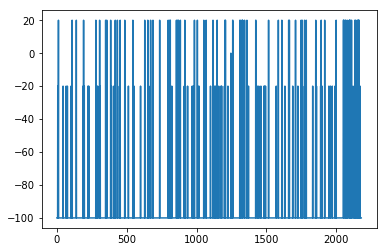

In [190]:
plt.plot(hist.history.get('episode_reward'))

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [195]:
dqn.compute_q_values(env.step(0))

ValueError: Error when checking : expected flatten_11_input to have 3 dimensions, but got array with shape (1, 4)

In [165]:
np.argmax(model.predict(np.array(env.state).reshape(1, 1, 10)))

0

In [158]:
env.reset()
env.render()
while(True):
    if env.current == env.ai:
        act = np.argmax(model.predict(np.array(env.state).reshape(1, 1, 10)))
    else:
        act = int(input())
    _, reward, done, _ = env.step(act)
    env.render()
    if done:
        print(reward)
        break

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
+---+---+---+
| 0 | 0 | 0 |
| 0 | 0 | 0 |
| 0 | 0 | 0 |
+---+---+---+
+---+---+---+
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 0 |
+---+---+---+
1
+---+---+---+
| 0 | 2 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 0 |
+---+---+---+
+---+---+---+
| 0 | 2 | 1 |
| 0 | 1 | 0 |
| 0 | 0 | 0 |
+---+---+---+
6
+---+---+---+
| 0 | 2 | 1 |
| 0 | 1 | 0 |
| 2 | 0 | 0 |
+---+---+---+
+---+---+---+
| 1 | 2 | 1 |
| 0 | 1 | 0 |
| 2 | 0 | 0 |
+---+---+---+
8
+---+---+---+
| 1 | 2 | 1 |
| 0 | 1 | 0 |
| 2 | 0 | 2 |
+---+---+---+
+---+---+---+
| 1 | 2 | 1 |
| 0 | 1 | 1 |
| 2 | 0 | 2 |
+---+---+---+
7
+---+---+---+
| 1 | 2 | 1 |
| 0 | 1 | 1 |
| 2 | 2 | 2 |
+---+---+---+
-20


In [11]:
print(x)

1


In [52]:
dqn.test(env, 2, visualize=True)

Testing for 2 episodes ...
2 [[0 0 0]
 [1 0 0]
 [0 0 0]]
2 [[0 0 0]
 [1 0 2]
 [0 0 0]]
2 [[0 0 0]
 [1 0 2]
 [1 0 0]]
2 [[0 0 0]
 [1 2 2]
 [1 0 0]]
2 [[1 0 0]
 [1 2 2]
 [1 0 0]]
Episode 1: reward: -10.000, steps: 5
2 [[0 0 0]
 [1 0 0]
 [0 0 0]]
2 [[0 0 0]
 [1 0 2]
 [0 0 0]]
2 [[0 0 0]
 [1 0 2]
 [1 0 0]]
2 [[0 0 0]
 [1 2 2]
 [1 0 0]]
2 [[1 0 0]
 [1 2 2]
 [1 0 0]]
Episode 2: reward: -10.000, steps: 5
